# Mechanical vibrations : ``vibmec`` module

## *Daniel B. M. Matos*

In [1]:
import numpy as np
import scipy.linalg as sc
import matplotlib.pyplot as plt
import pandas as pd
from pandas import ExcelWriter
from numba import jit

In this notebook, it will be explained every function of ``vibmec`` module

## 1. ``Matrix``

The matrix function its used to build Stiffness and Mass matrix, as the following script

In [2]:
def Matrix(Nome,Nn):
    
    ## Nome : Nome do arquivo(lembrar de colocar ".xlsx").
    ## Nn : Número de nós.
    
#-------------------------------------------------------------------------    
#1. Importar planilha do Excel  
#-------------------------------------------------------------------------  
    Arquivo = pd.read_excel(Nome)
#-------------------------------------------------------------------------     
#2. Montar vetor de coordenadas ( X e Y de cada nó) 
#------------------------------------------------------------------------- 
    cx = list(Arquivo['Cx'])[0:Nn]
    cy = list(Arquivo['Cy'])[0:Nn]
#-------------------------------------------------------------------------     
#3. Montar matriz identidade( Nó inicial e final de cada barra)
#-------------------------------------------------------------------------  
    Id1     = list(Arquivo['barra (nó 1)'])
    Id2     = list(Arquivo['barra (nó 2)'])
    Nb      = len(Id1)
                                
    ID      = np.zeros((2,Nb))
    ID[0,:] = Id1
    ID[1,:] = Id2
#-------------------------------------------------------------------------     
#4. Alocar as propriedades de cada barra
#-------------------------------------------------------------------------  
    A   = list(Arquivo['Area(m2)'])
    I   = list(Arquivo['Inércia(m4)'])
    RHO = list(Arquivo['Densidade'])

    E   = 28*10**9##[N/m2]
#------------------------------------------------------------------------- 
#5. Matriz identidade em relação aos graus de liberdade
#-------------------------------------------------------------------------  
    IDG = np.zeros((6,70))
    
    for i in range(3):
        
        IDG[i,:]   = ID[0,:]*3-2+i
        IDG[i+3,:] = ID[1,:]*3-2+i
#-------------------------------------------------------------------------        
#6. Comprimento de cada barra e cossenos diretores
#-------------------------------------------------------------------------  
    Lx   = np.zeros(Nb)
    Ly   = np.zeros(Nb)
    cosx = np.zeros(Nb)
    cosy = np.zeros(Nb)
    L    = np.zeros(Nb)

    for n in range (Nb):
    
        k1      = int(ID[0,n] -1)  # 'k' são os buscadores da matriz Id
        k2      = int(ID[1,n] -1)
        Lx[n]   = cx[k2] - cx[k1]
        Ly[n]   = cy[k2] - cy[k1]
        L[n]    = np.sqrt(Lx[n]**2 + Ly[n]**2)
        cosx[n] = Lx[n]/L[n]
        cosy[n] = Ly[n]/L[n]
    
#-------------------------------------------------------------------------        
#7. Montagem das matrizes de massa e rigidez
#-------------------------------------------------------------------------  

    K = np.zeros((132,132))
    M = np.zeros((132,132))

    for i in range (Nb):
    
    #7.1 Matriz de rigidez local da barra
        Ke =np.array([[E*A[i]/L[i], 0, 0, -E*A[i]/L[i],0 ,0 ],
                  [0, 12*E*I[i]/(L[i]**3), 6*E*I[i]/(L[i]**2), 0,
                   -12*E*I[i]/(L[i]**3),6*E*I[i]/(L[i]**2)],
                  [0,6*E*I[i]/(L[i]**2), 4*E*I[i]/L[i], 0, 
                   -6*E*I[i]/(L[i]**2), 2*E*I[i]/L[i] ],
                  [-E*A[i]/L[i], 0, 0, E*A[i]/L[i],0 ,0 ],
                  [0, -12*E*I[i]/(L[i]**3), -6*E*I[i]/(L[i]**2),
                   0,12*E*I[i]/(L[i]**3),-6*E*I[i]/(L[i]**2)],
                  [0,6*E*I[i]/(L[i]**2), 2*E*I[i]/L[i], 0,
                   -6*E*I[i]/(L[i]**2), 4*E*I[i]/L[i] ]])

    #7.2 Matriz de massa local da barra
        Me = ((RHO[i]*A[i]*L[i])/420)*np.array([[140, 0, 0, 70, 0, 0],
         [0, 156, 22*L[i], 0, 54, -13*L[i]],
         [0, 22*L[i], 4*(L[i]**2), 0, 13*L[i], -3*(L[i]**2)],
         [70, 0, 0, 140, 0, 0],
         [0, 54, 13*L[i], 0, 156, -22*L[i]],
         [0, -13*L[i], -3*(L[i]**2), 0, -22*L[i], 4*(L[i]**2)]])
   
    #7.3 Matriz de rotação 
        R = np.array([[cosx[i], cosy[i], 0, 0 ,0 ,0],
                  [-cosy[i], cosx[i],0, 0, 0, 0],
                  [0,0,1,0,0,0],                     
                  [0,0,0,cosx[i], cosy[i], 0],
                  [0, 0, 0,-cosy[i], cosx[i],0],
                  [0,0,0,0,0,1]])
        
    #7.4 Rotação das matrizes
                     
        KT = np.dot(np.dot(R.T, Ke),R)             
        MT = np.dot(np.dot(R.T, Me),R)
    
    #7.5 Matrizes temporárias
        k_temp1 = np.zeros((132,132))    
        m_temp1 = np.zeros((132,132))
        
   #7.6 Alocação das matrizes temporárias na matriz global
        m = int(IDG[0,i]-1)
        n = int(IDG[2,i])
        o = int(IDG[3,i]-1)
        p = int(IDG[5,i])
    
        k_temp1[m:n,m:n] = KT[0:3,0:3]
        k_temp1[o:p,m:n] = KT[3:6,0:3]
        k_temp1[m:n,o:p] = KT[0:3,3:6]
        k_temp1[o:p,o:p] = KT[3:6,3:6]
    
        K += k_temp1 
    
        m_temp1[m:n,m:n] = MT[0:3,0:3]
        m_temp1[o:p,m:n] = MT[3:6,0:3]
        m_temp1[m:n,o:p] = MT[0:3,3:6]
        m_temp1[o:p,o:p] = MT[3:6,3:6]
    
        M += m_temp1 
#-------------------------------------------------------------------------         
    return K,M

## 2. ``Restr``

Eliminação dos graus de liberdade restritos

In [3]:
def Restr(K,M,Nr): 
    
    ## K  : Matriz de rigidez
    ## M  : Matriz de massa
    ## Nr : Lista com os graus de liberdade restritos
#-------------------------------------------------------------------------      
# 1. Excluindo as linhas e colunas restritas
#-------------------------------------------------------------------------  
    Kr_1 = np.delete(K,Nr,0)
    Kr   = np.delete(Kr_1,Nr,1)
    Mr_1 = np.delete(M,Nr,0)
    Mr   = np.delete(Mr_1,Nr,1)
#-------------------------------------------------------------------------  
#2. Exportando as matrizes de Rigidez e massa para o Excel
#-------------------------------------------------------------------------  
    df     = pd.DataFrame(Kr)
    writer = ExcelWriter('Matriz de rigidez.xlsx')
    df.to_excel(writer,'Sheet1', index=False) 
    writer.save()
                               
    df1    = pd.DataFrame(Mr)
    writer = ExcelWriter('Matriz de massa.xlsx')
    df1.to_excel(writer,'Sheet1', index=False)
    writer.save()
#-------------------------------------------------------------------------     
    return Kr,Mr

## 3. ``Eig``

Cálculo das frequências naturais e determinação das formas modais

In [4]:
def Eig(Kr,Mr,N,d,Na):
    
    ## Kr : Matriz de rigidez restringida
    ## Mr : Matriz de rigidez restringida
    ## N  : Número de modos desejados
    ## d  : distancia entre pilares
    ## Na : número de andares do pórtico
    
#-------------------------------------------------------------------------
#1. Cálculos de autovalores e autovetores
#-------------------------------------------------------------------------
    w21,Phi1 = sc.eig(Kr,Mr)

    iw   = w21.argsort()
    w21  = w21[iw]    ## Garantindo a ordem dos autovalores e autovetores
    Phi1 = Phi1[:,iw]

    wr = np.real(w21)
    wk = np.sqrt(wr)
    fk = np.real(wk/(2*np.pi))
    wk = 2*np.pi*fk
#-------------------------------------------------------------------------
#2.Printando as freqências naturais desejadas
#-------------------------------------------------------------------------
    for k in range(N):
        print(k+1, "ª frequencia natural = {0:3.2f}Hz".format(fk[k]),"\n")
    
#-------------------------------------------------------------------------
#3.Plotando os modos de vibração desejados
#-------------------------------------------------------------------------

    plt.figure(1, figsize=(8,8))
    x   = np.arange(Na+1)
    Phi = Phi1[::12,0:N]

    for k in range(N):
        pk     = np.zeros(Na+1)
        pk[1:] = Phi[:,k]
        pk    /= np.max(np.abs(pk))
        plt.subplot(1,N,k+1)
    
        for n in range(Na):
        
            o  = np.linspace(pk[n+1],pk[n+1]+3*d,10)
            y1 = np.ones(Na)*n+1          ##Criação dos andares horizontais
        
            plt.plot(o, y1, 'b')
    
        plt.plot(pk[1:],x[1:],'bo')
        plt.plot(pk[1:]+d, x[1:], 'bo')
        plt.plot(pk[1:]+2*d, x[1:], 'bo')   ## Plotagem das linhs e dos nós
        plt.plot(pk[1:]+3*d, x[1:], 'bo')
        plt.plot(pk,x,'b')
        plt.plot(pk+d, x,'b')
        plt.plot(pk+2*d, x,'b')
        plt.plot(pk+3*d, x,'b')
    
    
    
        plt.xlim(-2, 12);  plt.ylabel(str(k+1));
        plt.ylim( 0.0, 11);
        plt.title('f= {0:3.2f}Hz'.format(fk[k]));
        plt.grid(True)
#-------------------------------------------------------------------------    
    return fk,wk,Phi1

## 4. ``Rayleigh``

Monta a matriz de amortecimento de Rayleigh

In [5]:
def Rayleigh(Kr,Mr,wk,z1,z2): 
    
    ## Kr : Matriz de rigidez restringida
    ## Mr : Matriz de rigidez restringida
    ## wk : Frequencias naturais(rad/s)
    ## z1 : Fator de amortecimento do primeiro modo 
    ## z2 : Fator de amortecimento do segundo modo


#-------------------------------------------------------------------------
#1. Montagem dos coeficientes do sistema de Rayleigh
#------------------------------------------------------------------------- 
    zeta    = np.zeros(2)
    zeta[0] = z1
    zeta[1] = z2
    a0      = -2*(wk[0]*wk[1])/(wk[0]**2 - wk[1]**2)
    a1      = a0*( zeta[0]*wk[1] - zeta[1]*wk[0])
    a2      = a0*(-zeta[0]/wk[1] + zeta[1]/wk[0])      


    Cr  = a1*Mr + a2*Kr              
#-------------------------------------------------------------------------
#2. Exportação da matriz para o Excel
#------------------------------------------------------------------------- 

    df2    = pd.DataFrame(Cr)
    writer = ExcelWriter('Matriz de Amortecimento.xlsx')
    df2.to_excel(writer,'Sheet1', index=False)
    writer.save()
#-------------------------------------------------------------------------    
    return Cr

In [6]:
@jit
def shinozuka(Sg,df,tf,w,t,P):
    ag = np.zeros(tf)
    S  = np.zeros(tf)
    for i in range(tf):
        for j in range(tf):
            S[j] =np.sqrt(2*Sg[j]*df)*np.cos(w[j]*t[i]+ P[j])
        ag[i] = np.sum(S)
    return ag

## 5. ``Kanai_Tajimi``

Monta o espectro de Kanai-Tajimi conforme as características do solo

In [7]:
def Kanai_Tajimi(Ap,tipo,duraçao,dt):
    
    ## Ap      : Peek Ground Acceleration
    ## tipo    : tipo de solo 
    ## duraçao : tempo de duração do sinal
    ## dt      : Passo temporal

#------------------------------------------------------------------------- 
#1. Definição dos parâmetros do solo
#------------------------------------------------------------------------- 
    g   = 9.806
    Ap *= g
    pg  = 3
    tf  = int(duraçao/dt)
    
    if tipo == 'rocha':
        wg = 8 * np.pi
        zg = 0.6
    elif tipo == 'solo_rigido':
        wg = 5* np.pi
        zg = 0.6
    elif tipo == 'solo_mole':
        wg = 2.4* np.pi
        zg = 0.85
#------------------------------------------------------------------------- 
#2. Montagem do espectro de Kanai-Tajimi
#------------------------------------------------------------------------- 
    f  = np.linspace(0,25,tf)
    df = f[1]-f[0]
    w  = 2*np.pi*f
    #S0 = (Ap**2)/((pg**2)*(np.pi*wg*((1/(2*zg))+2*zg)))
    #Sg = S0*((1+4*(zg**2)*(w/wg)**2)/(((1-(w/wg)**2)**2)+4*(zg**2)*(w/wg)**2))
    S0 = 0.03*zg/(np.pi*wg*(4*zg**2+1))
    Sg = S0*(wg**4+4*wg**2 * zg**2 * w**2)/((w**2-wg**2)**2 + 4*w**2*zg**2*wg**2)

    plt.figure(2, figsize=(8,4)) 
    plt.plot(f,Sg,'b')
    plt.xlabel('frequência(Hz)'); plt.ylabel('Densidade espectral(m²/s³)');
    plt.xlim(0,20); plt.ylim(0,max(Sg)*2);plt.title(' Espectro de aceleração')
    plt.grid(True)
#------------------------------------------------------------------------- 
#3. Método de Shinozuka e Jan para passagem ao domínio do tempo
#------------------------------------------------------------------------- 
    import random 
    P = np.zeros(tf)
    for i in range(tf):
        P1   = random.uniform(0,2*np.pi)
        P[i] = P1
   
    ag = np.zeros(tf)
    t  = np.linspace(0,duraçao,tf)
    S  = np.zeros(tf)
    ag = shinozuka(Sg,df,tf,w,t,P)

    ag*= Ap/np.max(abs(ag))  ## Normalização das acelerações
#------------------------------------------------------------------------- 
#4. Aplicação da função de envoltória 
#------------------------------------------------------------------------- 

    env  =np.ones(tf)
    env1 = np.arange(int(0.05*tf))/(0.05*tf)
    env2 = (1.148698355**t[0:int(0.8*tf)])/64/4
    env[0:int(0.05*tf)] = env1
    env[int(0.2*tf):tf] = env2[::-1]

    plt.figure(3,figsize=(8,4))

    plt.plot(t,ag,'b')
    plt.xlabel('Tempo (s)'); plt.ylabel('Aceleração (m/s²)');
    plt.xlim(0,duraçao); plt.ylim(-Ap,Ap);plt.title(' Aceleração do solo')
    plt.grid(True)

    plt.figure(4,figsize=(8,4))
    plt.plot(t,ag,'c')
    plt.plot(t,env,'r--',t,-env,'r--')
    plt.xlabel('Tempo (s)'); plt.ylabel('Aceleração (m/s²)');
    plt.xlim(0,duraçao); plt.ylim(-Ap,Ap);plt.title(' Função de envoltória')
    plt.grid(True)

    age = ag*env
    age*= Ap/np.max(abs(age))
    plt.figure(5,figsize=(8,4))
    plt.plot(t,age,'b')
    plt.xlabel('Tempo (s)'); plt.ylabel('Aceleração (m/s²)');
    plt.xlim(0,duraçao); plt.ylim(-Ap,Ap);
    plt.title('Aceleração do solo parametrizada')
    plt.grid(True)
#-------------------------------------------------------------------------     
    return t,age,Sg

## 5.``Sismo``

Criação do vetor de forças externas

In [8]:
def Sismo(Mr,age,t):
    
    ## Mr  : Matriz de rigidez restrita 
    ## t   : lista do tempo discretizado 
    ## age : sinal de aceleração discetizado 
#------------------------------------------------------------------------- 
#1. Montagem do vetor de forças externas 
#-------------------------------------------------------------------------     
    ag       = np.zeros((1,len(t)))
    ag[0,:]  = age
    tf       = int(len(t))
    n        = int (len(Mr[0,:]))
    B        = np.zeros((n,1))
    B[::3,0] = np.ones(int(n/3))
    F        = np.dot(np.dot(-Mr,B),ag)
    
    
    plt.figure(6,figsize=(8,4))   
    plt.plot(t,F[n-3 ,:],'b')
    plt.xlabel('Tempo (s)'); plt.ylabel('Força N')
    plt.xlim(0,max(t)); plt.ylim(-max(F[n-3])*1.2,max(F[117])*1.2);
    plt.title('Força no 10º pavimento')
    plt.grid(True)
#-------------------------------------------------------------------------     
    return F,B

## 6. ``Newmark``

Resolve a equação de equilíbrio dinâmico pelo método de Newmark

In [9]:
def Newmark(Kr,Mr,Cr,F,u0,v0,t):
    
     ## Kr: Matriz de rigidez restringida
     ## Mr : Matriz de rigidez restringida
     ## Cr : Matriz de amortecimento
     ## F : Vetor de força discretizado no tempo
     ## t : lista do tempo discretizado
#------------------------------------------------------------------------- 
#1. Criação dos arrays necessários
#-------------------------------------------------------------------------       
    tf  = int(len(t))
    n   = len(F[:,0])
    A   = np.zeros((n,tf))
    v   = np.zeros((n,tf))
    d   = np.zeros((n,tf))
    dt  = t[1]-t[0]
    
    d[0:n,0] = u0
    v[0:n,0] = v0
    
#------------------------------------------------------------------------- 
#2. Determinação das constantes do método de Newmark
#-------------------------------------------------------------------------
    delta = 0.5
    alfa  = 0.25
    a0    = 1/(alfa*(dt**2))
    a1    = 1/(alfa*dt)
    a2    = (1/(2*alfa))-1
    a3    = delta/(dt*alfa)
    a4    = delta/alfa - 1
    a5    = (dt/2)*(delta/alfa - 2)

    A[:,0] = np.dot(np.linalg.inv(Mr),(F[:,0]-np.dot(Cr,
     v[:,0])-np.dot(Kr,d[:,0])))
    
    d4 = a0*Mr + a3*Cr + Kr
    D  = np.linalg.inv(d4)
#------------------------------------------------------------------------- 
#3. Resolução da equação de equilíbrio dinâmico
#-------------------------------------------------------------------------
    for i in range(tf-1):
        d1       = np.dot(Mr,(a0*d[:,i]+ a1*v[:,i] + a2*A[:,i]))
        d2       = np.dot(Cr,(a3*d[:,i]+ a4*v[:,i] + a5*A[:,i]))
        d3       = F[:,i+1]+ d1 + d2
        d[:,i+1] = np.dot(D,d3)
        v[:,i+1] = a3*(d[:,i+1] - d[:,i]) - a4*v[:,i] - a5*A[:,i]
        A[:,i+1] = a0*(d[:,i+1] - d[:,i]) - a1*v[:,i] - a2*A[:,i]
    
    return d,v,A

## 7. `` Finite_diff``

Utiliza o método das diferenças finitas centrais para a resolução da equação de equilíbrio dinâmico

In [10]:
def Finite_diff(Kr,Mr,Cr,F,u0,v0,t):
    
    tf     = len(t)

    n      = len(F[:,0])
    d      = np.zeros((n,tf+1))
    d[:,1] = u0
    
    dt     = t[1]-t[0]
    
    a0     =np.dot(np.linalg.inv(Mr),(F[:,0]-np.dot(Cr,v0)-np.dot(Kr,u0)))
    d[:,0] = (dt**2)/2*a0 - dt*v0 + u0
    
    
    C1     = np.linalg.inv(1/(dt**2)*Mr + 1/(2*dt)*Cr)
    C2     = Kr - 2/(dt**2)*Mr 
    C3     = 1/(dt**2)*Mr - 1/(2*dt)*Cr
    
    
    for i in range(1,tf):
     
        d[:,i+1] = np.dot(C1,(F[:,i-1] - np.dot(C2,d[:,i]) - np.dot(C3,d[:,i-1])))
                   
                   
    return d
    
    
    

## 8. ``Modal_Analysis``

Resolucão da equação de equilíbrio a partir da superposicão modal


In [68]:
def Modal_Analysis(Kr,Mr,Cr,Fr,u0,v0,Phi1,n,t):
    
    tf = int(len(t))
    
    Km = np.diagonal(np.dot(np.dot(Phi1[:,0:n].T,Kr),Phi1[:,0:n]))
    Mm = np.diagonal(np.dot(np.dot(Phi1[:,0:n].T,Mr),Phi1[:,0:n]))
    Cm = np.diagonal(np.dot(np.dot(Phi1[:,0:n].T,Cr),Phi1[:,0:n]))
    Fm = np.dot(Phi1[:,0:n].T,Fr)
    D  = np.zeros((n,tf))
    V  = np.zeros((n,tf))
    A  = np.zeros((n,tf))
    
    dt =t[1]-t[0]
    
    V0 = (np.dot(np.linalg.inv(Phi1),v0)) 
    D0 = (np.dot(np.linalg.inv(Phi1),u0))
#----------------------------------
    
    
    return Km,Mm,Cm,Fm,D0,V0

## 9. ``Freqdomain``

indica a força máxima equivalente tendo como entrada um espectro de pseudo-acelerações

In [17]:
def Freqdomain(Kr,Mr,Phi1,r,n,Mt,Sa):

    ln = np.dot(np.dot(-Phi1[:,n],Mr),r)
    Km = np.dot(np.dot(Phi1[:,n].T,Kr),Phi1[:,n])
    Mm = np.dot(np.dot(Phi1[:,n].T,Mr),Phi1[:,n])
    Fsmax = np.dot(Mr,Phi1[:,n]*ln/Mm*Sa)
    return Fsmax,ln

## 10. ``Duhamel``

In [96]:
def Duhamel(Wn,Zn,F,Mm,u0,v0,t):
    
    tf = int(len(t))
    n  = len(Wn)
    dt = t[1] - t[0]
    U0 = np.zeros((n,tf))
    U  = np.zeros((n,tf))
    
    for i in range(n):
        
        wn = Wn[i]
        zn = Zn[i]
        
        wd = wn*np.sqrt(1- zn**2)
        
        e = np.exp(zn*wn*t)
        s = np.sin(wd*t)
        c = np.cos(wd*t)
        
        A = dt*np.cumsum(e*c*F[i,:])
        B = dt*np.cumsum(e*s*F[i,:])
        
        U[i,:] = (u0[i]*c+(v0[i]+u0[i]*zn*wn)*s/wd)/e
        
        U[i,:] +=(A*s-B*c)/e/wd/Mm[i]
        
    return U
        
    
    

## 10. Testando os algorítmos de integração

In [104]:

w = 2

t = np.linspace(0,100,3000)
K = np.array([[75,-25],
             [-25,25]])

M = np.array([[10,0],
             [0,5]])
zk = [0.01,0.02]

f1 = 40*np.sin(w*t)
f2 = 50*np.cos(w*t)
F  = np.zeros((2,len(t)))
F[0,:] = f1
F[1,:] = f2

u0 = np.array([-0.73355,-0.685172])


v0 = np.array(([-2.57656,1.61612]))

w21,Phi1 = sc.eig(K,M)

iw   = w21.argsort()
w21  = w21[iw]  
Phi1 = Phi1[:,iw]

wr = np.real(w21)
wk = np.sqrt(wr)
fk = np.real(wk/(2*np.pi))
wk = 2*np.pi*fk

C = Rayleigh(K,K,wk,zk[0],zk[1])


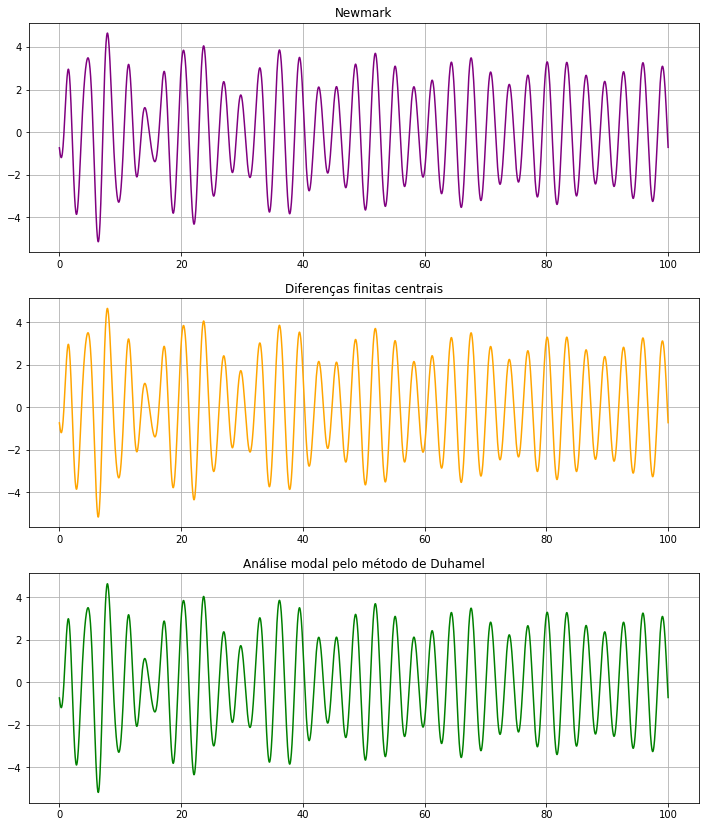

In [105]:
#------------------------------------------------------------------
#1. Aplicanco Newmark
#------------------------------------------------------------------
d,v,a = Newmark(K,M,C,F,u0,v0,t)
#------------------------------------------------------------------
#2. Aplicanco a análise modal
#------------------------------------------------------------------
Km,Mm,Cm,Fm,D0,V0 = Modal_Analysis(K,M,C,F,u0,v0,Phi1,2,t)
#------------------------------------------------------------------
#3. Aplicanco diferenças finitas
#------------------------------------------------------------------
df    = Finite_diff(K,M,C,F,u0,v0,t)
#------------------------------------------------------------------
#4. Aplicando Duhamel na Análise modal
#------------------------------------------------------------------
U = Duhamel(wk,zk,Fm,Mm,D0,V0,t)
D = np.dot(Phi1,U)

#------------------------------------------------------------------
#4. Plotando os gráficos
#------------------------------------------------------------------
plt.figure(1,figsize=(12,1.618*12))

plt.subplot(4,1,1)
plt.plot(t,d[0],'purple')
plt.title('Newmark')
plt.grid(True)

plt.subplot(4,1,2)
plt.plot(t,df[0,1:],'orange')
plt.title('Diferenças finitas centrais')
plt.grid(True)

plt.subplot(4,1,3)
plt.plot(t,D[0],'g')

plt.title('Análise modal pelo método de Duhamel')
plt.grid(True)


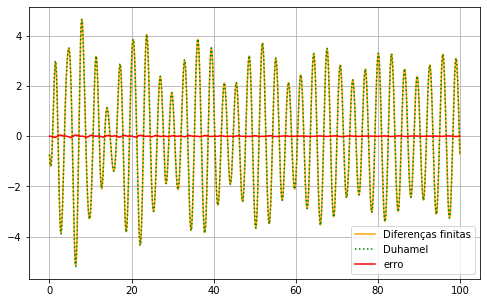

In [129]:
plt.figure(12,figsize=(5*1.618,5))
plt.plot(t,d[0],'orange')
plt.plot(t,D[0],'g:')
plt.plot(t,d[0]-D[0],'r')
plt.legend(('Diferenças finitas', 'Duhamel','erro'))
plt.grid(True)

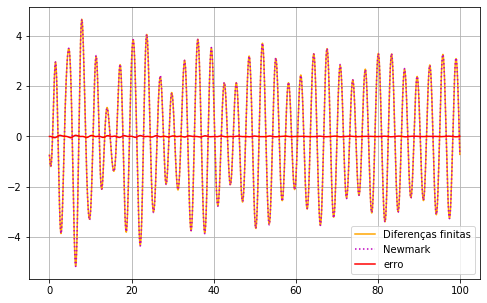

In [130]:
plt.figure(12,figsize=(5*1.618,5))
plt.plot(t,d[0],'orange')
plt.plot(t,df[0,1:],'m:')
plt.plot(t,d[0]-D[0],'r')
plt.legend(('Diferenças finitas', 'Newmark','erro'))
plt.grid(True)

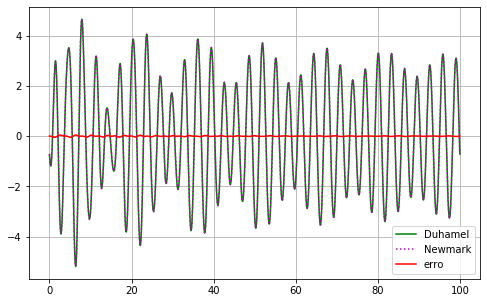

In [128]:
plt.figure(12,figsize=(5*1.618,5))
plt.plot(t,D[0],'g')
plt.plot(t,df[0,1:],'m:')
plt.plot(t,d[0]-D[0],'r')
plt.legend(('Duhamel', 'Newmark','erro'))
plt.grid(True)